Import Library

In [ ]:
# Frequently used libraries
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [ ]:
# Libraries for image data processing
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Libraries for model building
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# TersorFlow Ver
print(tf.__version__)

2.19.0


Data Loading

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yeshaputri","key":"cb98522e7893deae9e9c8dbf0452fcba"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 83% 286M/346M [00:06<00:01, 34.6MB/s]
100% 346M/346M [00:06<00:00, 58.8MB/s]


In [ ]:
!unzip intel-image-classification.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain

Data Preparation

In [ ]:
# train dan test
train_dir = "seg_train/seg_train"
test_dir = "seg_train/seg_train"

# Dataset gabungan
combined_dir = "seg_dataset"

In [ ]:
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Copy files and folders from train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Copy files and folders from test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

Dataset Checking

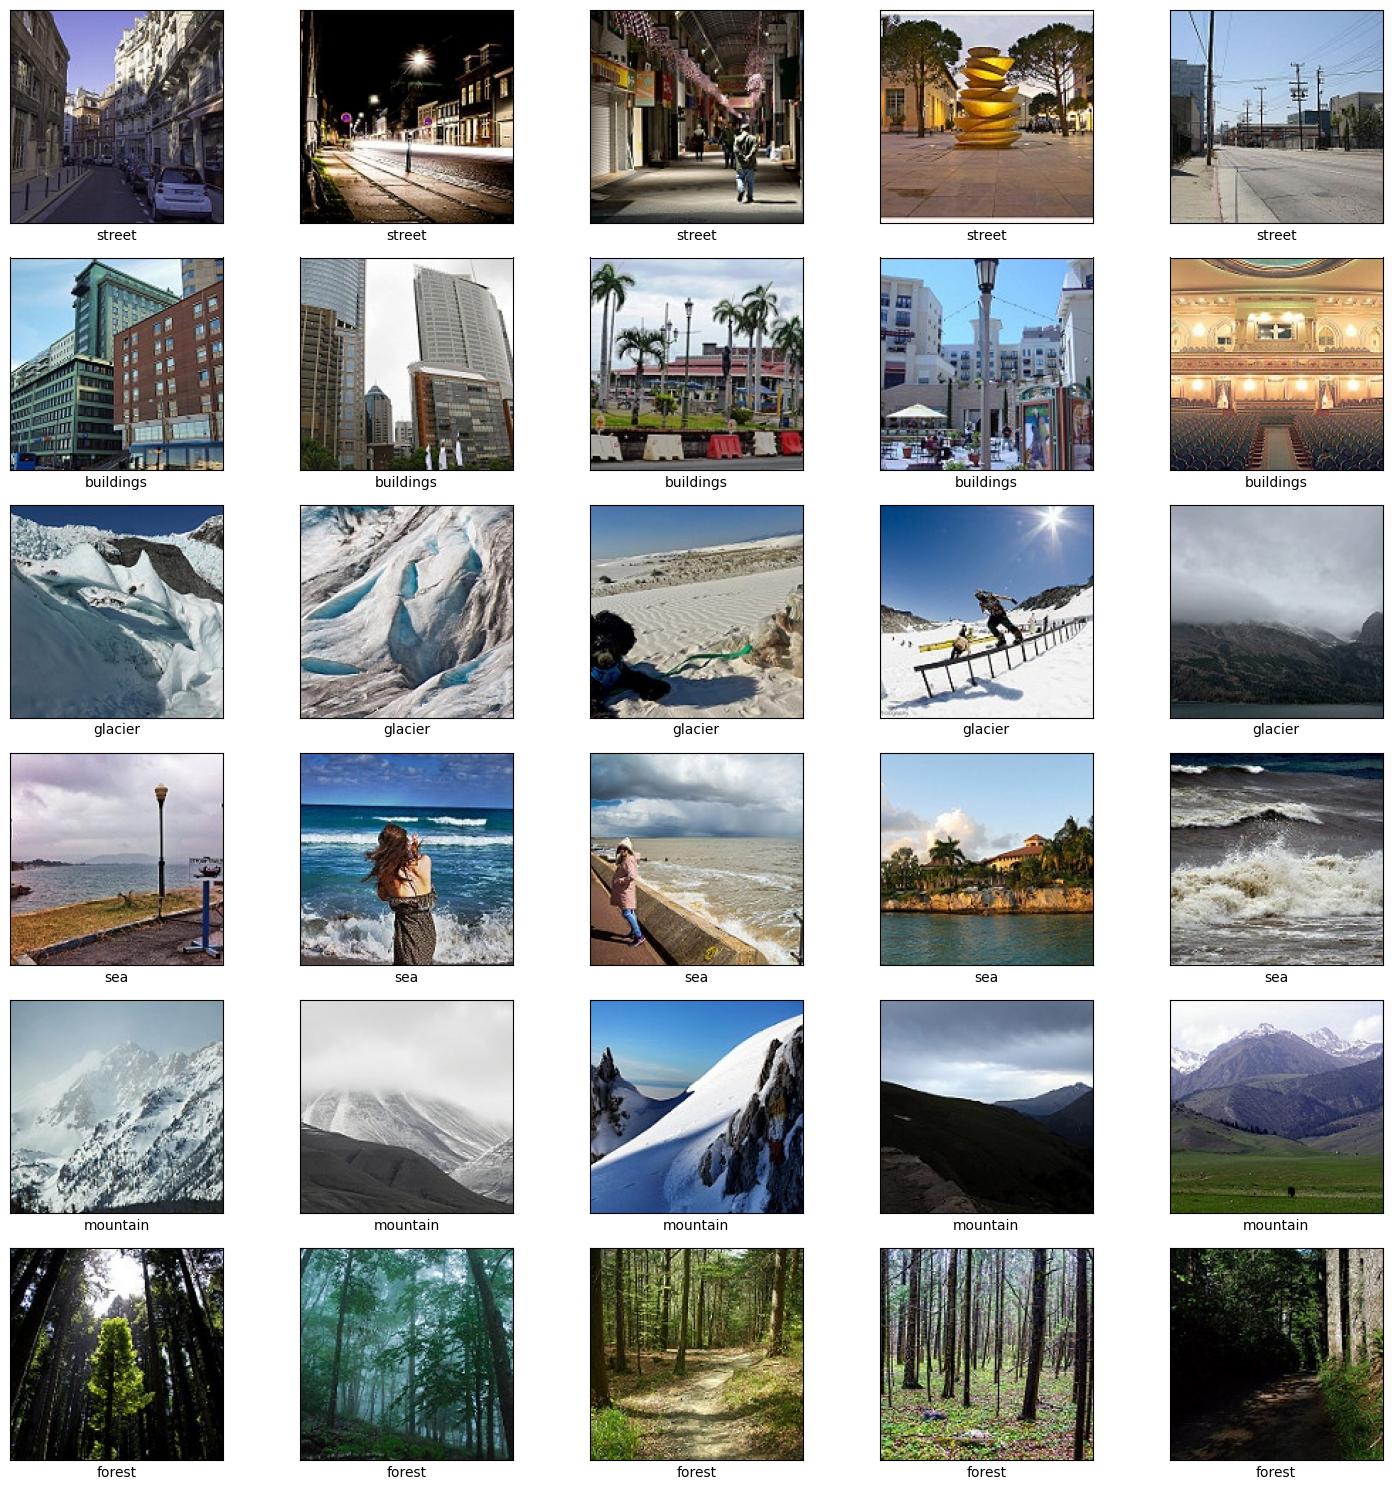

In [ ]:
import matplotlib.pyplot as plt

intel_image = {}

# Source train path
path = "seg_train/"
path_sub = os.path.join(path, "seg_train")
for i in os.listdir(path_sub):
    intel_image[i] = os.listdir(os.path.join(path_sub, i))

# Randomly display 5 images under each of the 2 classes of data.
path_sub = "seg_dataset"

# Randomly displays 5 images under each class from the training data.
fig, axs = plt.subplots(len(intel_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(intel_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

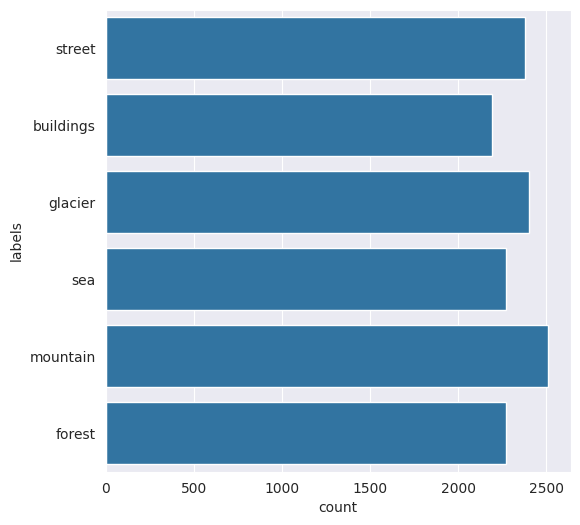

In [ ]:
import seaborn as sns

# Source path
intel_path = "seg_dataset"

# File name, file path, and labels in the data
file_name = []
labels = []
full_path = []

# Looping and save as a dataframe
for path, subdirs, files in os.walk(intel_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot the distribution of images in each class
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Data Splitting

In [ ]:
mypath= 'seg_dataset'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
buildings,2191
forest,2271
glacier,2404
mountain,2512
sea,2274
street,2382


In [ ]:
X = df['path']
y = df['labels']

# Train-Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [ ]:
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [ ]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

# Dataset Awal
datasource_path = "seg_dataset"
# Dataset Final
dataset_path = "Dataset-Final/"


set    labels   
test   buildings     419
       forest        465
       glacier       496
       mountain      483
       sea           483
       street        461
train  buildings    1772
       forest       1806
       glacier      1908
       mountain     2029
       sea          1791
       street       1921
dtype: int64 


                                  path     labels    set
8003         seg_dataset/sea/14831.jpg        sea  train
13458      seg_dataset/forest/9758.jpg     forest   test
10338     seg_dataset/forest/19227.jpg     forest  train
537    seg_dataset/buildings/15690.jpg  buildings  train
11599    seg_dataset/glacier/16131.jpg    glacier   test


In [ ]:
for index, row in tq(df_all.iterrows()):
    # Filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Destination folder directory
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # File destination
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Copy files from source to destination
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

Image Data Generator

In [ ]:
# Directory
TRAIN_DIR = "Dataset-Final/train"
TEST_DIR = "Dataset-Final/test"

train_buildings = os.path.join(TRAIN_DIR + '/buildings')
train_forest = os.path.join(TRAIN_DIR + '/forest')
train_glacier = os.path.join(TRAIN_DIR + '/glacier')
train_mountain = os.path.join(TRAIN_DIR + '/mountain')
train_sea = os.path.join(TRAIN_DIR + '/sea')
train_street = os.path.join(TRAIN_DIR + '/street')

test_buildings = os.path.join(TEST_DIR + '/buildings')
test_forest = os.path.join(TEST_DIR + '/forest')
test_glacier = os.path.join(TEST_DIR + '/glacier')
test_mountain = os.path.join(TEST_DIR + '/mountain')
test_sea = os.path.join(TEST_DIR + '/sea')
test_street = os.path.join(TEST_DIR + '/street')

print("Total number of buildings images in training set: ",len(os.listdir(train_buildings)))
print("Total number of buildings images in test set: ",len(os.listdir(test_buildings)))

print("\nTotal number of forest images in training set: ",len(os.listdir(train_forest)))
print("Total number of forest images in test set: ",len(os.listdir(test_forest)))

print("\nTotal number of glacier images in training set: ",len(os.listdir(train_glacier)))
print("Total number of glacier images in test set: ",len(os.listdir(test_glacier)))

print("\nTotal number of mountain images in training set: ",len(os.listdir(train_mountain)))
print("Total number of mountain images in test set: ",len(os.listdir(test_mountain)))

print("\nTotal number of sea images in training set: ",len(os.listdir(train_sea)))
print("Total number of sea images in test set: ",len(os.listdir(test_sea)))

print("\nTotal number of street images in training set: ",len(os.listdir(train_street)))
print("Total number of street images in test set: ",len(os.listdir(test_street)))

Total number of buildings images in training set:  1772
Total number of buildings images in test set:  419

Total number of forest images in training set:  1806
Total number of forest images in test set:  465

Total number of glacier images in training set:  1908
Total number of glacier images in test set:  496

Total number of mountain images in training set:  2029
Total number of mountain images in test set:  483

Total number of sea images in training set:  1791
Total number of sea images in test set:  483

Total number of street images in training set:  1921
Total number of street images in test set:  461


In [ ]:
# Create an ImageDataGenerator object that displays the image
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 8984 images belonging to 6 classes.
Found 2243 images belonging to 6 classes.
Found 2807 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(150,150,3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(2,2))

model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 455,750 (1.74 MB)

 Trainable params: 455,750 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels_train = train_generator.classes

# Count class weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_train),
    y=labels_train
)

# Convert to dictionary
class_weights = {i: w for i, w in enumerate(class_weights)}

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0559473436765396), 1: np.float64(1.0362168396770473), 2: np.float64(0.9805719275267409), 3: np.float64(0.9220032840722496), 4: np.float64(1.0448941614328913), 5: np.float64(0.9741921492084147)}


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 581s 2s/step - accuracy: 0.4259 - loss: 1.2824 - val_accuracy: 0.5782 - val_loss: 0.9867
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.5848 - loss: 0.9789 - val_accuracy: 0.7022 - val_loss: 0.8016
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.6910 - loss: 0.8092 - val_accuracy: 0.7561 - val_loss: 0.6759
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.7435 - loss: 0.6962 - val_accuracy: 0.7633 - val_loss: 0.6535
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.7736 - loss: 0.6224 - val_accuracy: 0.7726 - val_loss: 0.6427
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.7916 - loss: 0.5923 - val_accuracy: 0.8136 - val_loss: 0.5173
Epoch 7/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.8112 - loss: 0.5387 - val_accuracy: 0.8132 - val_loss: 0.5115
Epoch 8/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 571s 2s/step - accuracy: 0.8172 - loss: 0.5071 - val_accu

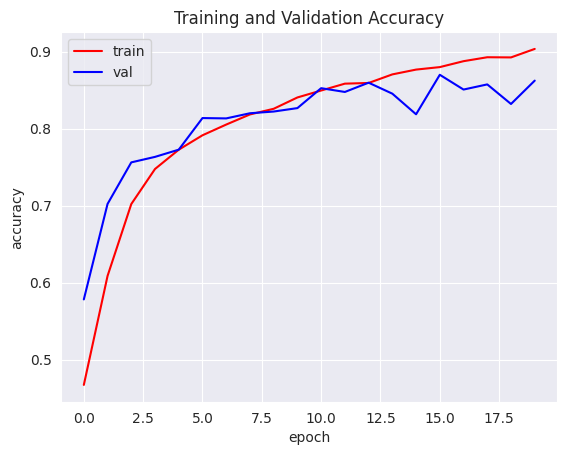

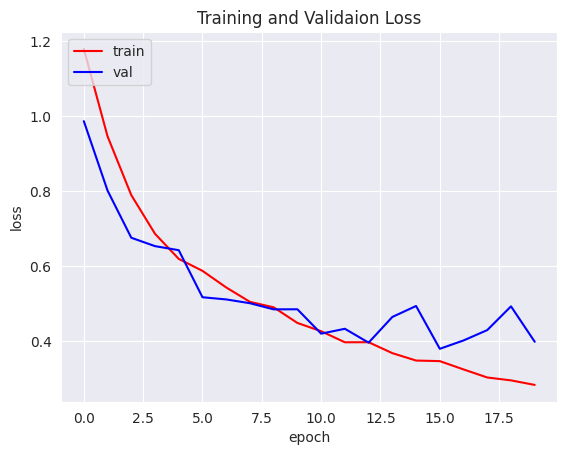

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

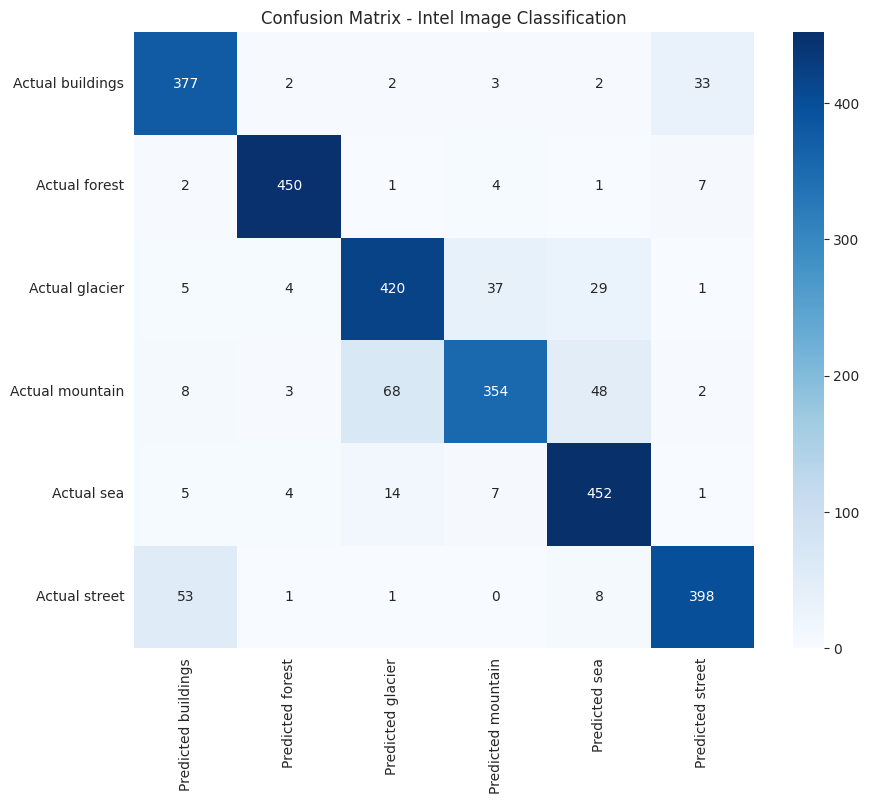


Classification Report:

              precision    recall  f1-score   support

   buildings     0.8378    0.8998    0.8677       419
      forest     0.9698    0.9677    0.9688       465
     glacier     0.8300    0.8468    0.8383       496
    mountain     0.8741    0.7329    0.7973       483
         sea     0.8370    0.9358    0.8837       483
      street     0.9005    0.8633    0.8815       461

    accuracy                         0.8732      2807
   macro avg     0.8749    0.8744    0.8729      2807
weighted avg     0.8747    0.8732    0.8722      2807



In [ ]:
test_generator.reset()
preds = model.predict(test_generator, verbose=0)

y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred),
    index=[f"Actual {c}" for c in class_names],
    columns=[f"Predicted {c}" for c in class_names]
)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Intel Image Classification")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


In [ ]:
print("Train Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Train Accuracy: 0.9033837914466858
Validation Accuracy: 0.8622380495071411


Simpan Model

In [ ]:
# Simpan sebagai SavedModel
model.save("model_savedmodel.keras")
print("Model SavedModel berhasil disimpan!")

Model SavedModel berhasil disimpan!


In [ ]:
# Simpan sebagai TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model TFLite berhasil disimpan!")

Saved artifact at '/tmp/tmpaamzl3_y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139930578633936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930710965712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578634320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578633744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578637200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578637968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578637776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578638160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578638544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932327782992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13993057863950

In [ ]:
# Simpan sebagai TFJS
!pip install tensorflowjs
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, "model_tfjs")
print("Model TFJS berhasil disimpan!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.38.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
xarray 2025.11.0 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.4 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


failed to lookup keras version from the file,
    this is likely a weight only file
Model TFJS berhasil disimpan!


In [ ]:
!zip -r model_tfjs.zip model_tfjs


  adding: model_tfjs/ (stored 0%)
  adding: model_tfjs/group1-shard1of1.bin (deflated 7%)
  adding: model_tfjs/model.json (deflated 86%)


In [ ]:
!zip -r model.tflite.zip model.tflite
from google.colab import files
files.download("model.tflite.zip")


  adding: model.tflite (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("model_tfjs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip freeze > requirements.txt
from google.colab import files
files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import os

# pastikan folder bersih
!rm -rf saved_model
os.makedirs("saved_model", exist_ok=True)

# simpan SavedModel
model.export("saved_model")

print("SavedModel berhasil disimpan di folder saved_model/")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139930578633936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930710965712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578634320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578633744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578637200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578637968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578637776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578638160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578638544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139932327782992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139930578639504: Te

In [ ]:
!zip -r saved_model.zip saved_model
from google.colab import files
files.download("saved_model.zip")


  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/saved_model.pb (deflated 86%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 64%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
import os

!rm -rf tflite
os.makedirs("tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [ ]:
class_names = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

with open("tflite/label.txt", "w") as f:
    for label in class_names:
        f.write(label + "\n")

print("Label berhasil disimpan ke tflite/label.txt")


Label berhasil disimpan ke tflite/label.txt


In [ ]:
!zip -r model.tflite.zip model.tflite
from google.colab import files
files.download("model.tflite.zip")


updating: model.tflite (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>